# 3_Classification

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## MNIST
This chapter explores the MNIST dataset, a set of 70,000 small images of handwritten digits. This dataset is known as the "hello world" of machine learning and many ML engineers like to test their classifications algorithms on the set.

Scikit-Learn provides many helper functions to download popular datasets. Below is code to download the MNIST dataset:

In [2]:
#fetch_openml returns unsorted dataset, this method sorts it
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including
- A `DESCR` key describing the dataset
- A `data` ley containing an array with one per row instance and one column per feature
- A `target` key containing an array with the labels

Analyze the structure of the arrays:

In [3]:
mnist.data.shape

(70000, 784)

In [4]:
X, y = mnist["data"], mnist["target"]
X.shape
#28*28 = 784

(70000, 784)

In [5]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is $28 \times 28$ pixels, and each feature simply represents one pixel's intensity, from 0 to 255 (white to black). 

Below is code examining one digit from the dataset. To grab a values from the dataset, an instance's feature vector needs to be grabed and reshaped into a $28 \times 28$ array and then displayed using Matplotlib's `imshow()` function:

Saving figure some_digit_plot


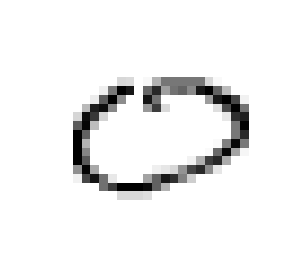

In [6]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

some_digit = X[30]
plot_digit(some_digit)


save_fig("some_digit_plot")
plt.show()

In [7]:
y[0]

0

The image looks like a 0 and the label is also a 0.

The dataset can be further explored:

In [8]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


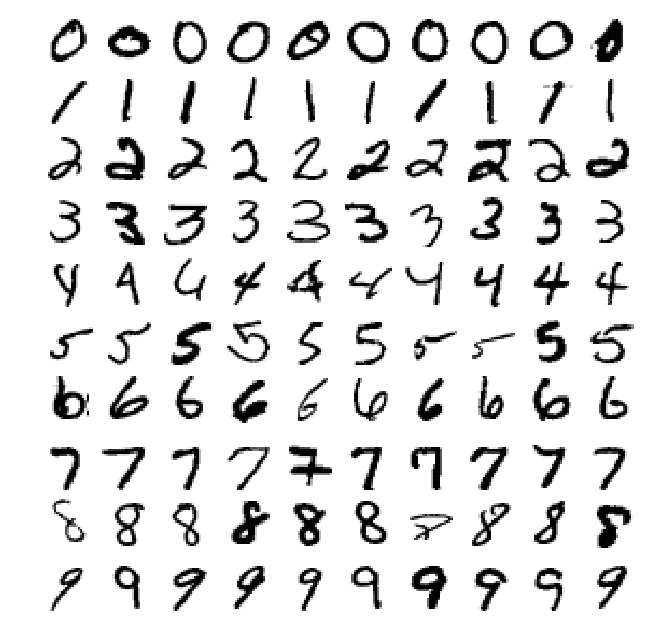

In [9]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

First, a test set should b created and set aside before inspecting the data closely. The MNIST dataset is already split into a training set (the first 60,000 images) and a test set (last 10,000 images):

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
#shuffle the data
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

The training set is shuffled which is good as this guarantees that all cross-validation folds will be similar (don't want to be missing some folds). Some learning algorithms are sensitive to the order of the training instances and they preform poorly if they get man similar instances in a row. Shuffling the dataset ensures this won't happen.

## Training a Binary Classifier
A more simplified problem to start with would be to only try to identify one digit - for example the number 0. This 0-detector will be an example of a *binary classifier*, being able to distinguish between 2 classes, 0 and not-0. First, create target vectors for this classification test

In [12]:
y_train_0 = (y_train == 0)
y_test_0 = (y_test == 0)

Next, pick a classifier and train it. A good place to start is with a *Stochastic Gradient Descent* (SGD) classifier using Scikit-Learn's `SGDClassifier` class. This classifier has the advantage of being able to handle very large datasets efficiently. This is because SGD deals with training instances independently, one at a time (which makes SGD suited for *online learning*). Create an `SGDClassifier` and train it on the whole trianing set:

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_0)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

> The `SGDClassifier` relies on randomness during training (hence the name "stochastic"). If you want reproducible results then set the `random_state` parameter.

The Classifier can now be used to detect images of the number 0

is this number a 0:  [ True]


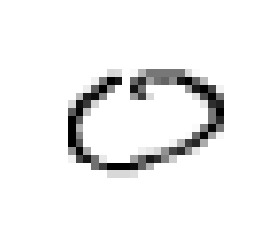

In [14]:
plot_digit(some_digit)

print("is this number a 0: ",sgd_clf.predict([some_digit]))

The classifier guessed that the image is a 0 which is correct. Now it is time to evaluate the model's performance.

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor. There are many performance measures available

### Measuring Accuracy Using Cross-Validation
**Implementing Cross-Validation**

In most cases, Scikit-learn does not provide enough control over the cross-validation process. In these cases, it is better to create a custom implementation from scratch. It is fairly straightforward. THe following code does roughly the same thing as Scikit-Learn's `cross_val_score()` function and prints the same result

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_0):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_0[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_0[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9884505774711264
0.98705
0.9893994699734987


The `StratifiedKFold` class preforms stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. THen it counts the number of correct predictions and outputs the ration of correct predictions.

The cross validation score can also be measured using the Scikit-Learn's `cross_val_score()` function with K-fold cross-validation with 3 folds. Remember that K-fold cross-validation means splitting the training set into K-folds (in this case 3), then making predictions and evaluating them on each fold using a model trained on the remaining folds.

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.98845058, 0.98705   , 0.98939947])

The SGD model produced above a 98% *accuracy* on all cross-validation folds. Next, try a classifier that classifies an images as the "not-0" class

In [17]:
from sklearn.base import BaseEstimator
class Never0Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [18]:
never_0_clf = Never0Classifier()
cross_val_score(never_0_clf, X_train, y_train_0, cv=3, scoring="accuracy")

array([0.89965, 0.903  , 0.9012 ])

This model has around 90% accuracy. This is because there are only about 10% of the images are 0s, so even if it guesses that an images is not 0 it will be right 90% of the time.

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with *skewed datasets* (i.e. when some classes are much more frequent than others)

### Confusion Matrix 
A *Confusion Matrix* is a better performance measure for a classifier. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 0s with 3s, look at the 0th row and 3rd column of the confusion matrix.

To compute the confusion matrix, first have a set of predictions on the test set, but keep it untouched (remember that the test set should be used at the end of the project once the classifier is ready to launch). Instead use the `cross_val_predict()` function:

In [19]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3)

`cross_val_predict()` preforms K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold, meaning that it can give a clean prediction for each instance in the training set ("clean" meaning that the prediction is made by a model that never say the data during training)

Now pass the target classes (y_train_0) and the predicted classes (y_train_pred) to the `confusion_matrix()` function:

In [20]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_0, y_train_pred)

array([[53667,   410],
       [  292,  5631]])

Each row in a *confusion matrix* represents represent an *actual class* while each column represents a *predicted class*. The first row of this matrix considers non-0 images (the *negative class*): 53,667 were correctly classified as non-0s (called *true negatives*), while the remaining 410 were wrongly classified as 0s (*false positives*). The second row considers the images of 0s (the *positive class*): 292 were wrongly classified as non-0s (*false negatives*), while the remaining 5,631 were correctly classified as 0s (*true positives*). A perfect classifier would have only true positives and true negatives, so its confusion matrix wuld have nonzer values only on its main diagonal (top left to bottom right):

In [21]:
y_train_perfect_predictions = y_train_0

confusion_matrix(y_train_0, y_train_perfect_predictions)

array([[54077,     0],
       [    0,  5923]])

The confusion matrix gives a lot of information, but sometimes a more concise metric is preferred. An interesting one to look at is the accuracy of the positive predictions called the *precision* of the classifier.

$$ precision = \frac{TP}{TP + FP}$$

Where TP is the number of true positives, and FP is the number of false positives

A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). This is not very useful since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named *recall*, also called *sensitivity* or *true positive rate* (TPR): this is the ratio of positive instances that are correctly detected  by the classifier.

$$ recall = \frac{TP}{TP + FN}$$

FN is of course the number of false negatives.

### Precision and Recall
Precision and recall is another function from Scikit-Learn used compute classifier metrics:

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_0, y_train_pred) # = 5631 /(5631+410)

0.9321304419798047

In [23]:
recall_score(y_train_0, y_train_pred) # = 5631 /(5631+292)

0.9507006584501098

This detector is still a decent model. When it claims an image represents a 0, it is correct only 93% of the time. It also detects 95% of the 0s.

It is often convenient to combine precision and recall into a single metric called the $F_1$ *score*, in particular this metric is good at comparing two classifiers. The $F_1$ score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high $F_1$ score if both recall and precision are high.

$F_1$ score equation:

$$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

To compute the $F_1$ score, call the `f1_score()` function:

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_0, y_train_pred)

0.9413239719157472

The $F_1$ score favors classifiers that have similar precision and recall. This is not always what is wanted: in some contexts precision is more important than recall and vise versa. An example is a video classifier that detects videos that are safe for kids; this example would prefer a classifier that rejects many good videos (low recall) but keeps only the safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up. Another example is a shoplifting surveillance detection algorithm; It can have low precision as long as it has 99% recall (so almost all cases of shoplifting get caught but with a few false alerts).

Unfortunately, having both metrics is hard: precision and recall are usually inversely related to each other. This is called the *precision/recall tradeoff*.

### Precision/Recall Tradeoff
This tradeoff can be analyzed within the `SGDClassifier` and how the model makes its classification decisions. On each instance, it computes a score based on a *decision function*, and if that score is greater than a threshold, it assigns the instance to the positive class, or else it assigns it to the negative class (ex. sigmoid function).
![title](PRtradeoff.png)

Using this image as an example SGD binary classifier for 5s and non-5s, suppose the *decision threshold* is positioned at the center arrow. At the right of this point there are 4 true positives (actual 5s) and one false positive (actual 6). This means at this threshold , there is an 80% precision (4 out of 5). But out of 6 actual 5s, the classifier detects only 4, so recall is 67% (4 out of 6). If the threshold is raised (moved to the right) the false positive become a true negative, but turns a true positive into a false negative. This increased precision to 100% and decreased recall to 50%. If the threshold is lowered (moved to the left) recall will increase and precision will decrease.

Scikit-Learn does not give access to the threshold variable directly, but gives access to the decision scores that it uses to make predicitons. Instead of calling the classifier's `predict()` method, call the `decision_function()` method which returns a score for each instance, and then makes predictions based on those scores using any threshold specified:

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([230799.61697403])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
threshold = 500000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

The `SGDClassifier` uses a threshold equal to 0, so it is the same result as just calling the `predict()` method (i.e. `True`). Raising the threshold decreases the recall. The image is a 0, but cannot detect it when the threshold is increased to 500,000. 

In order to determine what threshold to use, first get the scores of all instances in the training set using the `cross_val_predict()` method, this time specifying it to return the decision scores instead of predictions:

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3, method="decision_function")

The precision and recall can be computed with these scores for all possible thresholds using the `precision_recall_curve()` function. 

In [29]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

The precision and recall can be plotted as functions of the threshold value using Matplotlib.

Saving figure precision_recall_vs_threshold_plot


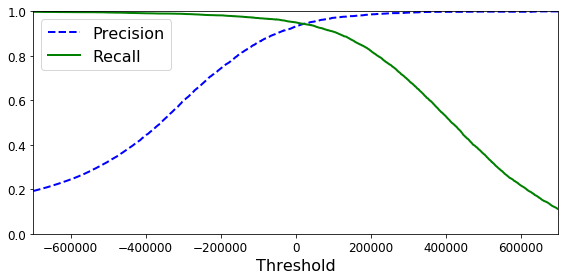

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

> The precision curve can often look bumpy since it is possible for precision to go slightly down when the threshold is raised.

Using this diagram makes it easy to select the threshold value that give the best precision.recall tradeoff for the specific task. Another good way to select a good precision/recall tradeoff is to plot precision directly against recall:

Saving figure precision_vs_recall_plot


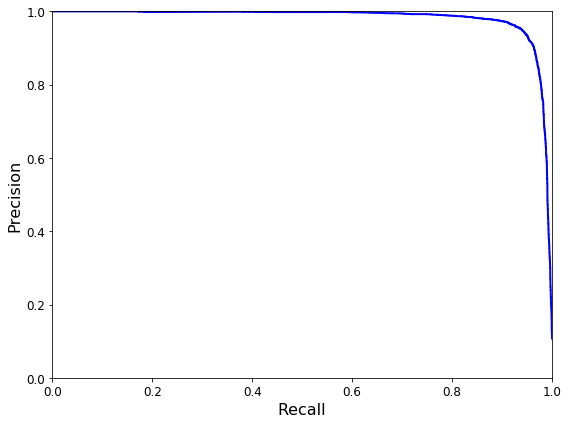

In [31]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

Precision tends to fall sharply around 95% recall. It is best to select a precision/recall tradeoff just before the drop (maybe 90% recall) but this is dependent on the problem.

As an example, if a model needs to aim for 95% precision, find use the first plot and find a threshold (around 40,000). To make predictions (on the training set for now), instead of calling the `predict()` method, just run the code:

In [32]:
y_train_pred_90 = (y_scores > 40000)

In [33]:
precision_score(y_train_0, y_train_pred_90)

0.9515659763819956

In [34]:
recall_score(y_train_0, y_train_pred_90)

0.9387134897855817

This model is now a 95% precision classifier. However, it should be noted that a high-precision classifier is not very useful if recall is too low.

### The ROC Curve

The *receiver operating characteristic* (ROC) curve is another common tool for binary classifiers. It is similar to the precision/recall curve but the ROC curve plots the *true positive rate* (another name for recall) against the *false positive rate*. The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the *true negative rate*, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) versus 1-*specificity*

To plot the ROC curve, compute the TPR and FPR for various threshold values, using the `roc_curve()` function:

In [35]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

Then the FPR can be ploted against the TPR using Matplotlib:

Saving figure roc_curve_plot


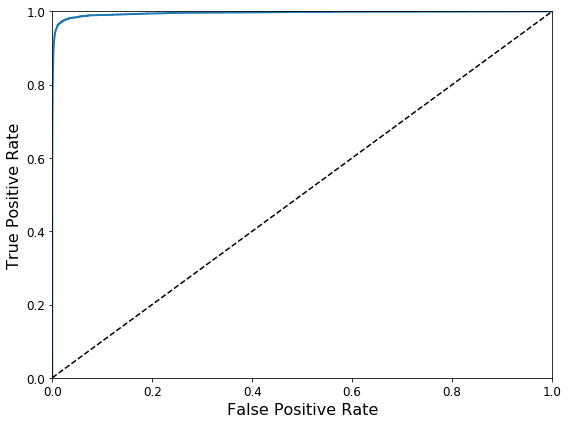

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

There is another tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; the best classifiers stay far away from this line.

Another way to compare classifiers is to measure the *area under the curve* (AUC). A perfect classifier will have a *ROC AUC* equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC AUC:

In [37]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_0, y_scores)

0.9954872129092529

> The ROC curve is so similar to the precision/recall (or PR) curve, but have slightly different uses. As rule of thumb, it is preferred to use the PR curve whenever the positive class is rare or when it is more important to deal with the false positives than the false negatives, and the ROC curve otherwise. In this example, the ROC AUC score makes the classifier look perfect, but this is because there are few positives (0s) compared to the negatives (non-0s). The PR curve shows that there still is some room for improvement (it could be closer to the top right corner).

The ROC curve and ROC AUC curve can also work on different classifiers, such as the `RandomForestSlcassifier`. First, the scores for each instance in the training set need to be obtained. Since the `RandomForestClassifier` class does not have a `decision_function()` method, instead use the `dict_proba()` method. Scikit-Learn classifiers generally have one or the other. THe `predict_proba()` method returns an array containign a row per instance and a column per class, each containing the probability that the given instance belongs to the given class (e.g. 70% chance that the image is a 0):

In [38]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_0, cv=3,
                                    method="predict_proba")

To plot the ROC curve, the plot needs scores, not probabilities. A simple solution is to use the positive class's probability as the score.

In [39]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_0,y_scores_forest)

Saving figure roc_curve_comparison_plot


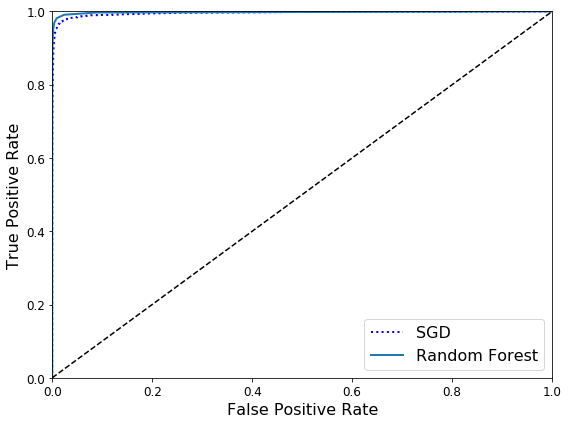

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [41]:
roc_auc_score(y_train_0, y_scores_forest)

0.9976144205376747

The `RandomForestClassifier`'s ROC curve is better than the previous model. It comes much closer to the top left corner. The ROC AUC score is also better.

In [42]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_0, cv=3)
precision_score(y_train_0, y_train_pred_forest)

0.9894037356321839

In [43]:
recall_score(y_train_0, y_train_pred_forest)

0.9301029883504981

The model also has around a 99% precision with 93% recall.

## Multiclass Classification
*multiclass classifiers* (also called *multinomial classifiers*) can distinguish between more than two classes.

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. Others (such as Support Vector Machines or Linear classifiers) are strictly binary classifiers. However, there are various strategies that can be used to preform multiclass classification using multiple binary classifiers.

For example, one way to create a system that can classify the digit images into 10 classes (0-9) is to train 10 binary classifiers, one for each digit. Then when an image is classified, grab the decision score from each classifier for that image and select the class whose classifier outputs the highest score. This is calle the *one-versus-all* (OvA) strategy (also called the *one-versus-the-rest*).

Another strategy is to train a binary classifier for every pair of digits: a 0-1 detector, 0-2 detector, 1-2 detector, etc. This is called the *one-versus-one* (OvO) strategy. If there are $N$ classes, then there needs to be $N \times (N-1)/2$ classifiers in total trained. For the MNIST problem, this means training 45 binary classifiers. When an image needs to be classified, run the image through all 45 classifiers and see which class wins the most duels. The main advantage OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.

Some algorithms (such as SVM classifiers) scale poorly with the size of the training set, so for these algorithms OvO is preferred since it is faster to train many classifiers on small training sets than training few classifiers on large training sets. For most binary classification algorithms, however, OvA is preferred.

Scikit-Learn detects when a binary classification algorithm is trying to be used on a multiclass classification task and it automatically runs OvA (except on SVM classifiers which use OvO):

In [44]:
sgd_clf.fit(X_train, y_train) #y_train not y_train_0
sgd_clf.predict([some_digit])

array([0], dtype=int8)

This code trains the `SGDClassifier` on the training set using the original target classes from 0-9 (`y_train`), instead of the 0-versus-all target classes (`y_train_0`). Then it makes a prediction (which was correct in this example). Under the hood, Scikit-Learn trained 10 binary classifiers, got their decision scores for the image, and selected the clas with the highest score.

The `decision_function()` method can verify this. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [45]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ 252974.13862535, -411763.08689255, -357593.82768596,
        -391936.60643001, -489279.16825965, -340028.6646928 ,
        -312940.97731024,  -64820.31439923, -146467.55327638,
        -503215.32464242]])

The highest score is the corresponding class 0:

In [46]:
np.argmax(some_digit_scores)

0

In [47]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [48]:
sgd_clf.classes_[0]

0

> When a classifier is trained, it stores the list of target classes in its `classes_` attribute, ordered by value. Since the classes in this case are numeric, the index matches the class itself.

To get Scikit-Learn to use one-versus-one or one-versus-all, there exists the `OneVsOneClassifier` or `OneVsRestClassifier` classes. Simply create an instance as pass a binary classifier to tis constructor. For example, this code creates a multiclass classifier using the OvO strategy, based on a `SGDClassifier`:

In [49]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([0], dtype=int8)

In [50]:
len(ovo_clf.estimators_)

45

The same can be done on a `RandomForestClassifier`:

In [51]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([0], dtype=int8)

In this instance, Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers can directly classify instances into multiple classes. To get the list of probabilities that the classifier assigned to each instance class, call the `predict_proba()` method:

In [52]:
forest_clf.predict_proba([some_digit])

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

The classifier is fairly confident about its prediction: it has a 100% probability that the image is a 0 and a 0% probability that it is not a 0.

To evaluate these classifiers, cross validation needs to be used. Below is cross validation on the `SGDClassifier`:

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84993001, 0.81769088, 0.84707706])

It gets over 81% on all test folds. A random classifier would get a 10% accuracy, so this score is not that bad, but it could do better. For example, simply scaling the inputs increases accuracy above 90%:

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91211758, 0.9099955 , 0.90643597])

## Error Analysis
After exploring data preparation options, trying out different models, and fine-tuning their hyperparameters using `GridSearchCV`, a promising model should have been selected. To continue improving this model, the types of errors it makes can be analyzed.

First look at the confusion matrix. predictions need to be made using the `cross_val_predict()` function, then call the `confusion_matrix()` function:

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5749,    4,   22,   11,   11,   40,   36,   11,   36,    3],
       [   2, 6490,   43,   24,    6,   41,    8,   12,  107,    9],
       [  53,   42, 5330,   99,   87,   24,   89,   58,  159,   17],
       [  46,   41,  126, 5361,    1,  241,   34,   59,  129,   93],
       [  20,   30,   35,   10, 5369,    8,   48,   38,   76,  208],
       [  73,   45,   30,  194,   64, 4614,  106,   30,  170,   95],
       [  41,   30,   46,    2,   44,   91, 5611,    9,   43,    1],
       [  26,   18,   73,   30,   52,   11,    4, 5823,   14,  214],
       [  63,  159,   69,  168,   15,  172,   54,   26, 4997,  128],
       [  39,   39,   27,   90,  177,   40,    2,  230,   78, 5227]])

It's often more convenient to look at an image representation of the confusion matrix, using Matplotlib's `matshow()` function:

In [56]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


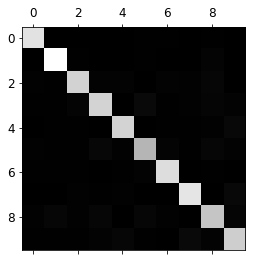

In [57]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

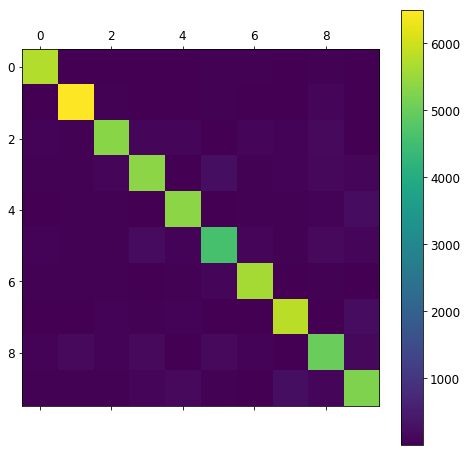

In [58]:
plot_confusion_matrix(conf_mx)

This confusion matrix looks fairly good since most of the images are on the main diagonal; this means that they were classified correctly. The 5s look slightly darker than the other digits, which could mean there are fewer images of 5s in the dataset or that the classifier does not preform well as well on classifying 5s than other digits. This can be verified.

As a way to focus on the plot errors, first divide each value in the confusion matrix by the number of images in the corresponding class so the error rates can be compares instead of the absolute number of errors (which would make abundant classes look unfairly bad):

In [59]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Fill the diagonal with zeros to keep only the errors and plot the result:

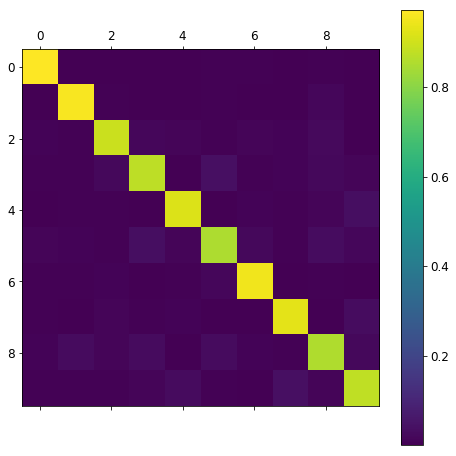

In [60]:
plot_confusion_matrix(norm_conf_mx)

This graph makes it easy to spot the kinds of errors the classifier makes. Remember that rows represent actual classes, while columns represent predicted classes. The columns for classes 8 and 9 look bright which shows that many images get misclassified as 8s or 9s. Similarly, the rows for classes 8 and 9 are also bright, showing that 8s and 9s are often confused with other digits. Conversely, some rows are pretty dark such as row 1 which means that most 1s are classified correctly (a few are confused with 8s). Notice that the errors are not perfectly symmetrical; an example being there are more 5s misclassified as 8s than the reverse.

Analyzing the confusing matrix can often give insights on way to improve the classifier. Looking at this plot, it seems that effort should be spend on improving classification of 8s and 9s as well as fixing the specific 3/5 confusion. One method is to gather more training data for these digits. Another could be to engineer new features that would help the classifier- for example, writing an algorithm to count the number of closed loops.

Analyzing individual errors can also be a good way to gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming. FOr example, plot examples of 3s and 5s (the `plot_digits()` function just uses Matplotlib's `imshow()` function).

Saving figure error_analysis_digits_plot


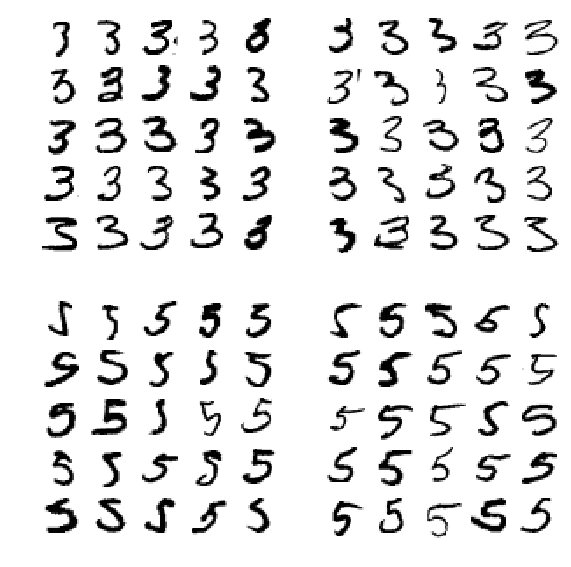

In [61]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

The two $5\times5$ blocks on the left show digits classified as 3s, and the two $5\times5$ blocks on the right show images classified as 5s. Some of the digits that the classifier gets wrong (i.e. in the bottom-left and top-right blocks) are so badly written that even a human would have trouble classifying them (5 on the 6th row 5th column looks like a 3). However, most misclassified images seem like obvious errors and it's hard to understand why the classifier made the mistakes it did. The reason is that the `SGDCLassifier` is a simple linear model. All it does is assign a weight per class to each pixel and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. So since 3s and 5s differ only by a few pixels, this model will easily confuse them.

The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If a 3 is drawn with the junction slightly shifted to the left, the classifier might classify it as a 5 and vice versa. This classifier is quite sensitive to image shifting and rotation. One way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotates. This will probably help reduce other errors as well.

## Multilabel Classification
In some cases a classifier may need to output multiple classes for each instance. For example, consider a face recognition classifier: what should it do if it recognizes several people on the same picture? It shoudl attatch one label per person it recognizes. If a classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1,0,1] (ues Alice, no Bob, yes Charlie). Such a classification system that outputs multiple binary labels is called a *multilabel classification* system.

Below is a simple example using the `KNeighborsClassifier`:

In [62]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7) #class for nums >=7
y_train_odd = (y_train % 2 == 1) #class for odd nums
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

This code creates a `y_multilabel` array containing two target labels for each image: the first indicates whether or not the digit is large (>=7) and the second indicates whether it is odd. The next lines create a `KNeighborsClassifier` instance (which supports multilabel classification) and train it using the multiple targets array. Now a prediction can be made, and notice that it outputs two labels:

In [63]:
knn_clf.predict([some_digit])

array([[False, False]])

0 is less than 7 and is not odd, so the classifier worked.

There are many ways to evaluate a multilabel classifier, and selecting the right metric depends on the project. For example, one approach is to measure the $F_1$ score for each individual label (or any other binary classifier metric used earlier), then simply compute the average score. This code computes the average $F_1$ score across all labels:

In [64]:
#slow runtime
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-4)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525

This assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier's score on pictures of Alice. One simple option is to give each label a weight equal to its *support* (i.e. the number of instances with that target label). To do this, simply set `average="weighted"` in the preceding code.

## Multioutput Classification
*Multioutput-multiclass classification* (or simply *multioutput classification*) is simply a generalization of multilabel classification where each label can be multiclass (i.e. it can have more than two possible values)

This can be illustrated within a system that removes nose from images. The system will take as input a noisy digit image, and it should output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0-255). It is thus an example of a multioutput classification system.

> The line between classification and regression is sometimes blurry, such as in this example. Predicting pixel intensity is more akin to a regression than to classification. Moreover, multioutput systems are not limited to classification tasks; there are systems that outputs multiple labels per instance, including both class labels and value labels.

Start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy's `randint()` function. The target images will be the original images:

In [65]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Look at an image from the test set:

Saving figure noisy_digit_example_plot


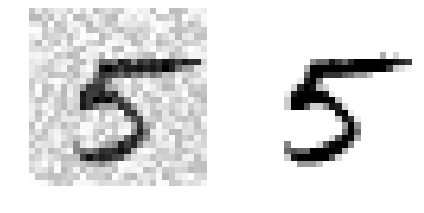

In [66]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig("noisy_digit_example_plot")
plt.show()

On the left is the noisy input image and the right is the clean target image. Train the classifier and make it clean this image:

Saving figure cleaned_digit_example_plot


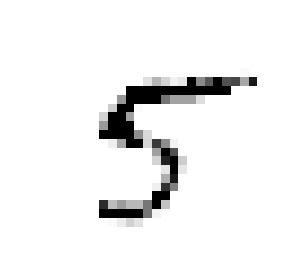

In [67]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")

This output looks close enough to the target image.

## Exercises
**1) MNIST model**

Build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Use the `KNeighborsClassifier` and tweak the hyperparameters to achieve this. (94 min runtime)

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 94.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=4,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [69]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [70]:
grid_search.best_score_

0.97325

In [71]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714